In [155]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import seaborn as sns
import sys
import scipy.stats as sc
import pandas as pd
import ffl

sys.path.append('../External_Functions')
from ExternalFunctions import UnbinnedLH, Chi2Regression, BinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax  # Useful functions to print fit results on figure

sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('deep', 10, desat = 1)
sns.set_palette(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams['figure.figsize'] = (16, 9)


In [156]:
df = pd.read_csv('data_DecayTimes.csv', header=None)
times = df.values.T
df

,0
0,0.49073
1,2.65275
2,1.35328
3,1.00767
4,0.27649
...,...
995,-0.17084
996,2.29557
997,0.13531
998,2.82462


## 5.2.1

Plot the distribution of decay times, and calculate the mean and median with uncertainty.

In [157]:
t = times[0]


decay_stats = df[0].describe()
mean = decay_stats['mean']
std = decay_stats['std']
SEM = std/np.sqrt(len(t))
median = decay_stats['50%']

mean_string = f'Mean {mean:.3f} +/- {SEM:.3f} s'


# Bootstrapping for error on Median

t = np.array(t)
N_samples = 1000

boot_median = np.zeros(N_samples)
for i in range(N_samples):
    boot_median[i] = np.median(np.random.choice(t, size=len(t), replace=True))

median_error = np.std(boot_median)

median_string = f'Median {median:.3f} +/- {median_error:.3f} s'


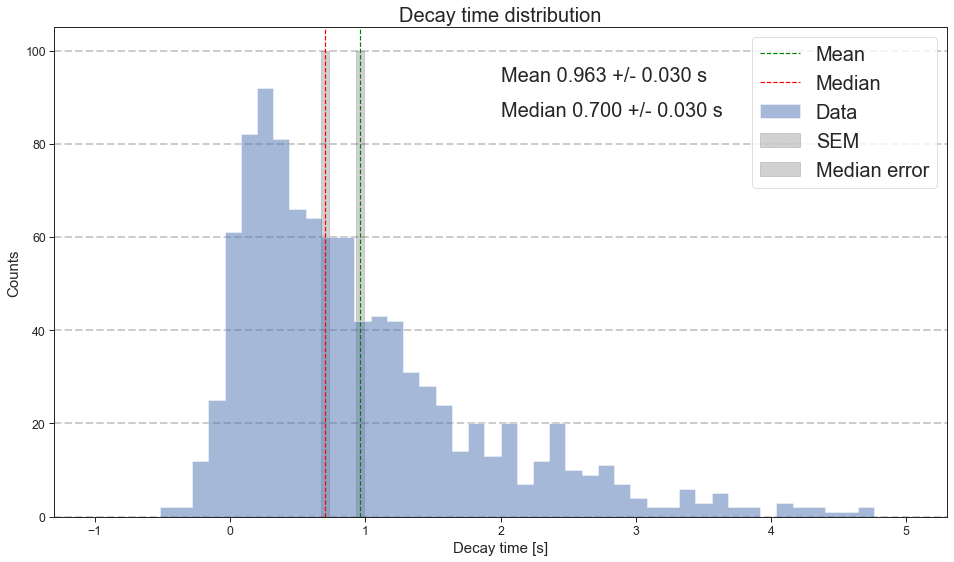

In [158]:

hist_range = [-1, 5]
N_bins = 50
fig, ax = plt.subplots()

counts, binedges, artist = ax.hist(t, bins=N_bins, range=hist_range, histtype='stepfilled', alpha=0.5, label='Data');
mask = counts > 0
counts = counts[mask]
ax.set_xlabel('Decay time [s]', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)

ax.set_title('Decay time distribution', fontsize=20)

ax.text(0.5, 0.92, mean_string, transform=ax.transAxes, fontsize=20, verticalalignment='top')
ax.text(0.5, 0.85, median_string, transform=ax.transAxes, fontsize=20, verticalalignment='top')

ax.axvline(mean, color='green', label='Mean', ls = '--')
ax.axvline(median, color='red', label='Median', ls = '--')
ax.fill_betweenx([0, 100], mean-SEM, mean+SEM, color='k', alpha=0.2, label='SEM')
ax.fill_betweenx([0, 100], median-median_error, median+median_error, color='k', alpha=0.2, label='Median error')

ax.legend(fontsize=20)

plt.savefig('saved_images/5_2_1.png')


## 5.2.2

Give a rough estimate of the decay time τ from fitting the high-t tail of the distribution.

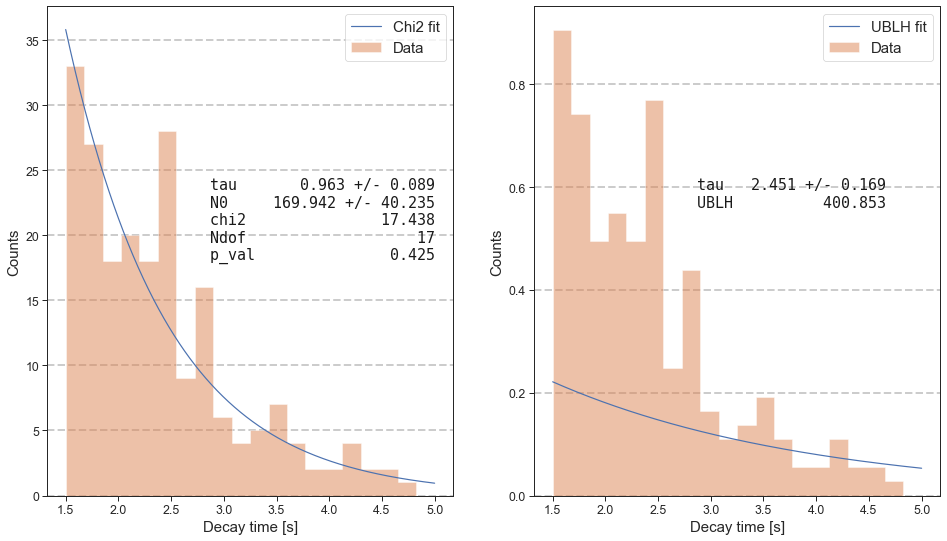

In [159]:
cut_off = 1.5
tail = t[ t > cut_off]


Nbins = 20
hist_range = [cut_off, 5]

bincenters, counts, err_counts = ffl.hist_for_fit(tail, Nbins, hist_range)

def exp(x, tau, N0):
    return  N0 * np.exp(-x/tau)

def exp_norm(x, tau):
    return   np.exp(-x/tau) / tau

Chi2_fit, Ndof, pval, par_dict = ffl.fit_with_chi2(exp, bincenters, counts, err_counts, [1/10, 150])
ublh_val, ublh_dict = ffl.UBLH_minuit(exp_norm, tail, [0.9])

x_fit = np.linspace(cut_off, 5, 1000)
y_fit = exp(x_fit, *Chi2_fit.values[:])
y_fit_ublh = exp_norm(x_fit, *ublh_val.values[:])

chi2_string = nice_string_output(par_dict, extra_spacing=2, decimals=3)
ublh_string = nice_string_output(ublh_dict, extra_spacing=2, decimals=3)

fig, ax = plt.subplots(1,2)

ax[0].plot(x_fit, y_fit, label='Chi2 fit')
ax[0].hist(tail, bins=Nbins, range=hist_range, histtype='stepfilled', alpha=0.5, label='Data');
add_text_to_ax(0.4, 0.65, chi2_string, ax[0], fontsize=15)
ax[0].set_xlabel('Decay time [s]', fontsize=15)
ax[0].set_ylabel('Counts', fontsize=15)
ax[0].legend(fontsize=15)

ax[1].plot(x_fit, y_fit_ublh, label='UBLH fit')
ax[1].hist(tail, bins=Nbins, range=hist_range, histtype='stepfilled', alpha=0.5, label='Data', density=True);
add_text_to_ax(0.4, 0.65, ublh_string, ax[1], fontsize=15)
ax[1].set_xlabel('Decay time [s]', fontsize=15)
ax[1].set_ylabel('Counts', fontsize=15)
ax[1].legend(fontsize=15)

plt.savefig('saved_images/5_2_2.png')

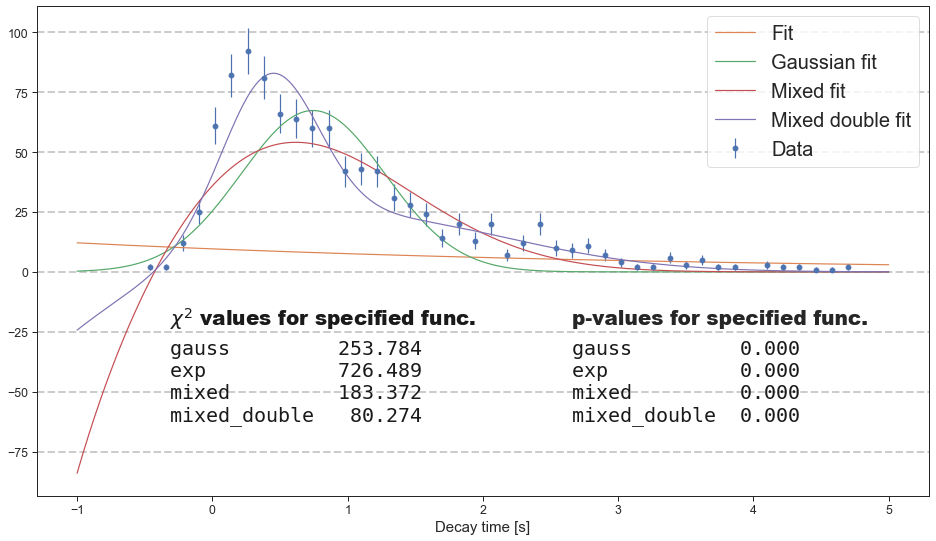

In [160]:
hist_range = [-1, 5]
N_bins = 50
binmids, counts, counts_err = ffl.hist_for_fit(t, N_bins, hist_range)
x_fit = np.linspace(-1, 5, 1000)

# fit with gaussian
def gauss(x, mu, sigma, N0):
    return N0 * ffl.gauss(x, mu, sigma)
gauss_val, gauss_ndof, gauss_pval, gauss_dict = ffl.fit_with_chi2(gauss, binmids, counts, counts_err, [0, 0.1, 100])
y_gauss = gauss(x_fit, *gauss_val.values[:])

# fit with exponential
trial_val, trial_ndof, trial_pval, trial_dict = ffl.fit_with_chi2(exp, binmids, counts, counts_err, [0.9, 100])
y_exp = exp(x_fit, *trial_val.values[:])


# fit with mixed
def mixed(x, mu, sigma, tau, N0, N1):
    return N0 * ffl.gauss(x, mu, sigma) + N1 * np.exp(-x/tau)

mixed_val, mixed_ndof, mixed_pval, mixed_dict = ffl.fit_with_chi2(mixed, binmids, counts, counts_err, [0.1, 0.1, 0.9, 500, 500])
y_mixed = mixed(x_fit, *mixed_val.values[:])

# fit with mixed double gauss
def mixed_double(x, mu1, mu2, sigma1, sigma2, tau, N0, N1, N2):
    return N0 * ffl.gauss(x, mu1, sigma1) + N1 * ffl.gauss(x, mu2, sigma2) + N2 * np.exp(-x/tau)
start_par = [0.1, 2.3, 0.1, 0.5, 0.9, 500, 500, 500]
mixed_double_val, mixed_double_ndof, mixed_double_pval, mixed_double_dict = ffl.fit_with_chi2(mixed_double, binmids, counts, counts_err, start_par)
y_mixed_double = mixed_double(x_fit, *mixed_double_val.values[:])

# make a dictionary all chi2 values
chi2_dict = {'gauss': gauss_val.fval , 'exp': trial_val.fval, 'mixed': mixed_val.fval, 'mixed_double': mixed_double_val.fval}
chi2_string = nice_string_output(chi2_dict, extra_spacing=2, decimals=3)

# make a dictionary with all p-values
pval_dict = {'gauss': gauss_pval , 'exp': trial_pval, 'mixed': mixed_pval, 'mixed_double': mixed_double_pval}
pval_string = nice_string_output(pval_dict, extra_spacing=2, decimals=3)


fig, ax = plt.subplots()
ax.errorbar(binmids, counts, yerr=counts_err, fmt='o', label='Data')
ax.plot(x_fit, y_exp, label='Fit')
ax.plot(x_fit, y_gauss, label='Gaussian fit')
ax.plot(x_fit, y_mixed, label='Mixed fit')
ax.plot(x_fit, y_mixed_double, label='Mixed double fit')


ax.text(0.15, 0.39, r'$\chi^2$ values for specified func.', weight='heavy', fontsize=20, transform=ax.transAxes, 
        verticalalignment='top', color='k');
add_text_to_ax(0.15, 0.32, chi2_string, ax, fontsize=20)

ax.text(0.6, 0.35, r'p-values for specified func.', weight='heavy', fontsize=20, transform=ax.transAxes,)
add_text_to_ax(0.6, 0.32, pval_string, ax, fontsize=20)

ax.set_xlabel('Decay time [s]', fontsize=15)


ax.legend(loc='upper right', fontsize=20)

plt.savefig('saved_images/5_2_3.png')